# Donor Modeling Pipeline MVP

## Overview

This notebook provides a clean, production-ready modeling pipeline that:

1. **Consumes pre-built features** from `donor_feature_construction.ipynb`
2. **Supports multiple cohorts** with flexible filtering
3. **Auto-detects task type** (classification vs regression) based on label
4. **Trains multiple models** (Logistic, LightGBM, CatBoost)
5. **Provides SHAP explanations** for model interpretability
6. **Generates comprehensive outputs** (metrics, lift tables, visualizations)

## Key Features

- ✅ **Cohort-based modeling**: Train separate models for different donor segments
- ✅ **Flexible label selection**: Choose any label from feature construction
- ✅ **Automatic preprocessing**: Handles numeric/categorical features
- ✅ **Model comparison**: Compare multiple algorithms per cohort
- ✅ **SHAP integration**: Understand feature importance and predictions
- ✅ **Production-ready outputs**: Exportable models, predictions, and metrics

## Workflow

```
donor_feature_construction.ipynb → train_features.csv, oot_features.csv
                                         ↓
                              donor_modeling_mvp.ipynb
                                         ↓
                    Models + Predictions + Metrics + SHAP
```

## 1. Setup & Configuration

All pipeline behavior is controlled through the configuration below.

In [1]:
# Standard libraries
import os
import json
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, precision_recall_curve
)

# Tree-based models
try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("⚠️  LightGBM not available")
'''
try:
    from catboost import CatBoostClassifier, CatBoostRegressor
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False
    print("⚠️  CatBoost not available")
'''
# SHAP for model explanations
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️  SHAP not available - install with: pip install shap")

# Configure
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_style('whitegrid')

print("✓ Imports complete")
print(f"  LightGBM: {'✓' if HAS_LGBM else '✗'}")
#print(f"  CatBoost: {'✓' if HAS_CATBOOST else '✗'}")
print(f"  SHAP: {'✓' if HAS_SHAP else '✗'}")

✓ Imports complete
  LightGBM: ✓
  SHAP: ✓


### Configuration Parameters

**Important**: Update these parameters to match your feature construction settings and modeling goals.

In [2]:
# ============================================================================
# MODELING CONFIGURATION
# ============================================================================

# --- Time Parameters (must match donor_feature_construction.ipynb) ---
E = 12                              # Only donors who gave in E months prior to T are eligible
T = pd.Timestamp('2023-07-01')      # Training features end date 
H = pd.Timedelta(days=365)          # Label prediction horizon
O = pd.Timedelta(days=365)          # Out-of-time lag to apply to T

# --- Data Paths ---
TRAIN_FEATURES_PATH = '/Users/matt.fritz/Desktop/train_features_251120.csv'  # Output from donor_feature_construction
OOT_FEATURES_PATH = '/Users/matt.fritz/Desktop/oot_features_251120.csv'      # Output from donor_feature_construction

# --- Label Selection ---
# Choose ONE label to predict. All other label_* columns will be excluded from features.
LABEL = 'label_gave_gt_10000_in_H'       

# Available labels (from donor_feature_construction):
#   - label_gave_any_in_H           (binary classification)
#   - label_gift_count_in_H         (count regression or classification)
#   - label_gift_amount_in_H        (continuous regression)
#   - label_median_gift_amount_in_H (continuous regression)

# --- Cohort Definitions ---
# Define donor segments to model separately
COHORTS = [
    {
        'name': 'bt_800_3000_12m_donors',
        'filters': {
            'gift_amount_green_12m': ('between', 800, 3000),
        }
    },
]

# --- Model Configuration ---
# Models to train (will be auto-selected based on task type)
CLASSIFICATION_MODELS = ['logreg', 'lgbm', 'catboost']  # For binary/multiclass labels
REGRESSION_MODELS = ['ridge', 'lgbm_regressor', 'catboost_regressor']  # For continuous labels

CALIBRATE_CLASSIFIERS = True        # Apply isotonic calibration to improve probability estimates

# --- SHAP Configuration ---
SHAP_ENABLED = True                 # Generate SHAP explanations (requires shap package)
SHAP_SAMPLE_SIZE = 500              # Number of samples for SHAP calculation (smaller = faster)
SHAP_TOP_FEATURES = 20              # Number of features to display in SHAP plots

# --- Evaluation Configuration ---
N_QUANTILES = 20                    # Number of quantiles for lift table (20 = vintiles)
LIFT_AT_K = [0.01, 0.05, 0.10]     # Calculate lift at top 1%, 5%, 10%

# --- Output Configuration ---
OUTPUT_DIR = './modeling_results'   # Directory for all outputs
SAVE_MODELS = True                  # Save fitted models to disk
SAVE_PREDICTIONS = True             # Save predictions to CSV
SAVE_SHAP = True                    # Save SHAP values to CSV

# --- Display Configuration ---
VERBOSE = True                      # Print progress messages

print("✓ Configuration loaded")
print(f"  Label: {LABEL}")
print(f"  Cohorts: {len(COHORTS)}")
print(f"  Output: {OUTPUT_DIR}")

✓ Configuration loaded
  Label: label_gave_gt_10000_in_H
  Cohorts: 1
  Output: ./modeling_results


## 2. Helper Functions

Utility functions for data processing, modeling, and evaluation.

In [3]:
def apply_cohort_filters(features: pd.DataFrame, cohorts: List[Dict]) -> Dict[str, pd.DataFrame]:
    """
    Apply cohort filters to feature dataframe.
    
    Parameters
    ----------
    features : pd.DataFrame
        Full feature dataset
    cohorts : List[Dict]
        List of cohort definitions with 'name' and 'filters'
        
    Returns
    -------
    Dict[str, pd.DataFrame]
        Dictionary mapping cohort name to filtered dataframe
    """
    results = {}
    
    for cohort in cohorts:
        name = cohort['name']
        filters = cohort['filters']
        
        # Start with all rows
        mask = pd.Series(True, index=features.index)
        
        # Apply each filter
        for col, spec in filters.items():
            if col not in features.columns:
                print(f"⚠️  Column '{col}' not found in features for cohort '{name}'")
                continue
            
            col_data = features[col]
            
            # Handle different filter types
            if isinstance(spec, tuple):
                op = spec[0]
                
                if op == 'between' and len(spec) == 3:
                    low, high = spec[1], spec[2]
                    mask &= (col_data >= low) & (col_data <= high)
                elif op == '>':
                    mask &= col_data > spec[1]
                elif op == '>=':
                    mask &= col_data >= spec[1]
                elif op == '<':
                    mask &= col_data < spec[1]
                elif op == '<=':
                    mask &= col_data <= spec[1]
                elif op == '==':
                    mask &= col_data == spec[1]
                elif op == '!=':
                    mask &= col_data != spec[1]
            elif isinstance(spec, list):
                mask &= col_data.isin(spec)
            else:
                mask &= col_data == spec
        
        results[name] = features[mask].copy()
        
        if VERBOSE:
            print(f"  Cohort '{name}': {mask.sum():,} donors ({mask.sum()/len(features)*100:.1f}%)")
    
    return results


def detect_task_type(y: pd.Series) -> str:
    """
    Auto-detect whether label is for classification or regression.
    
    Parameters
    ----------
    y : pd.Series
        Label column
        
    Returns
    -------
    str
        'classification' or 'regression'
    """
    # Binary labels (0/1) are classification
    unique_vals = y.dropna().unique()
    
    if len(unique_vals) <= 2 and set(unique_vals).issubset({0, 1}):
        return 'classification'
    
    # If all integers and < 20 unique values, could be classification
    if y.dtype in ['int64', 'int32'] and len(unique_vals) < 20:
        return 'classification'
    
    # Otherwise regression
    return 'regression'


def prepare_features(df: pd.DataFrame, selected_label: str) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Prepare features by removing all label columns except selected one.
    
    Parameters
    ----------
    df : pd.DataFrame
        Full dataset with features and labels
    selected_label : str
        Label column to keep
        
    Returns
    -------
    X : pd.DataFrame
        Features only
    y : pd.Series
        Selected label
    donor_ids : List[str]
        Donor IDs (if present)
    """
    # Save donor_id if present
    donor_ids = df['donor_id'].values if 'donor_id' in df.columns else None
    
    # Identify all label columns
    label_cols = [col for col in df.columns if col.startswith('label_')]
    
    # Drop all labels except selected, plus donor_id
    labels_to_drop = [col for col in label_cols if col != selected_label]
    X = df.drop(columns=labels_to_drop + ['donor_id'], errors='ignore')
    
    # Extract label
    if selected_label not in df.columns:
        raise ValueError(f"Label '{selected_label}' not found in dataframe")
    
    y = df[selected_label].copy()
    X = X.drop(columns=[selected_label], errors='ignore')
    
    return X, y, donor_ids


def identify_feature_types(X: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    Identify numeric and categorical features.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature dataframe
        
    Returns
    -------
    numeric_features : List[str]
        Numeric feature names
    categorical_features : List[str]
        Categorical feature names
    """
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return numeric_features, categorical_features


def create_preprocessor(numeric_features: List[str], 
                        categorical_features: List[str]) -> ColumnTransformer:
    """
    Create sklearn preprocessing pipeline.
    
    Parameters
    ----------
    numeric_features : List[str]
        Numeric feature names
    categorical_features : List[str]
        Categorical feature names
        
    Returns
    -------
    ColumnTransformer
        Preprocessing pipeline
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )
    
    return preprocessor


print("✓ Helper functions defined")

✓ Helper functions defined


### Model Factory

In [4]:
def get_model(model_name: str, task_type: str):
    """
    Get configured model based on name and task type.
    
    Parameters
    ----------
    model_name : str
        Name of model (e.g., 'logreg', 'lgbm', 'catboost')
    task_type : str
        'classification' or 'regression'
        
    Returns
    -------
    model
        Configured sklearn-compatible model
    """
    if task_type == 'classification':
        if model_name == 'logreg':
            return LogisticRegression(
                max_iter=1000,
                random_state=42,
                solver='lbfgs'
            )
        elif model_name == 'lgbm':
            if not HAS_LGBM:
                raise ImportError("LightGBM not installed")
            return lgb.LGBMClassifier(
                n_estimators=1000,
                learning_rate=0.03,
                max_depth=4,
                num_leaves=31,
                min_child_samples=300,
                subsample=0.8,
                colsample_bytree=0.6,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                class_weight='balanced'  # or use scale_pos_weight manually
            )
        elif model_name == 'catboost':
            if not HAS_CATBOOST:
                raise ImportError("CatBoost not installed")
            return CatBoostClassifier(
                random_state=42,
                verbose=0,
                iterations=100
            )
        else:
            raise ValueError(f"Unknown classifier: {model_name}")
    
    else:  # regression
        if model_name == 'ridge':
            return Ridge(
                alpha=1.0,
                random_state=42
            )
        elif model_name == 'lgbm_regressor':
            if not HAS_LGBM:
                raise ImportError("LightGBM not installed")
            return lgb.LGBMRegressor(
                random_state=42,
                verbose=-1,
                n_estimators=100
            )
        elif model_name == 'catboost_regressor':
            if not HAS_CATBOOST:
                raise ImportError("CatBoost not installed")
            return CatBoostRegressor(
                random_state=42,
                verbose=0,
                iterations=100
            )
        else:
            raise ValueError(f"Unknown regressor: {model_name}")


print("✓ Model factory defined")

✓ Model factory defined


### Evaluation Functions

In [5]:
def evaluate_classification(y_true: np.ndarray, 
                           y_pred_proba: np.ndarray,
                           n_quantiles: int = 20,
                           lift_at_k: List[float] = [0.01, 0.05, 0.10]) -> Dict:
    """
    Calculate classification metrics and lift table.
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels
    y_pred_proba : np.ndarray
        Predicted probabilities
    n_quantiles : int
        Number of quantiles for lift table
    lift_at_k : List[float]
        Top-K fractions for lift calculation
        
    Returns
    -------
    Dict
        Metrics and lift table
    """
    metrics = {}
    
    # Core metrics
    metrics['auc'] = roc_auc_score(y_true, y_pred_proba)
    metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    metrics['brier'] = brier_score_loss(y_true, y_pred_proba)
    metrics['baseline_rate'] = y_true.mean()
    
    # Lift table
    df_lift = pd.DataFrame({
        'y_true': y_true,
        'y_pred_proba': y_pred_proba
    })
    df_lift = df_lift.sort_values('y_pred_proba', ascending=False).reset_index(drop=True)
    df_lift['quantile'] = pd.qcut(df_lift.index, q=n_quantiles, labels=False, duplicates='drop') + 1
    
    lift_table = df_lift.groupby('quantile').agg(
        n=('y_true', 'count'),
        n_events=('y_true', 'sum'),
        avg_score=('y_pred_proba', 'mean')
    ).reset_index()
    
    lift_table['event_rate'] = lift_table['n_events'] / lift_table['n']
    lift_table['lift'] = lift_table['event_rate'] / metrics['baseline_rate']
    lift_table['cum_n'] = lift_table['n'].cumsum()
    lift_table['cum_events'] = lift_table['n_events'].cumsum()
    lift_table['cum_event_rate'] = lift_table['cum_events'] / lift_table['cum_n']
    lift_table['cum_lift'] = lift_table['cum_event_rate'] / metrics['baseline_rate']
    lift_table['cum_pct_captured'] = lift_table['cum_events'] / lift_table['n_events'].sum()
    
    metrics['lift_table'] = lift_table
    
    # Lift at K
    for k in lift_at_k:
        n_top_k = int(len(df_lift) * k)
        if n_top_k < 1:
            n_top_k = 1
    
        top_k_rate = df_lift['y_true'].iloc[:n_top_k].mean()
        metrics[f'lift_at_{int(k*100)}pct'] = top_k_rate / metrics['baseline_rate']
    
    return metrics


def evaluate_regression(y_true: np.ndarray, y_pred: np.ndarray) -> Dict:
    """
    Calculate regression metrics.
    
    Parameters
    ----------
    y_true : np.ndarray
        True values
    y_pred : np.ndarray
        Predicted values
        
    Returns
    -------
    Dict
        Regression metrics
    """
    metrics = {}
    
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    metrics['mean_actual'] = y_true.mean()
    metrics['mean_predicted'] = y_pred.mean()
    metrics['std_actual'] = y_true.std()
    metrics['std_predicted'] = y_pred.std()
    
    return metrics


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### SHAP Functions

In [6]:
def generate_shap_explanations(model,
                               X: pd.DataFrame,
                               model_name: str,
                               sample_size: int = 500) -> Optional[Dict]:
    """
    Generate SHAP values for model explanations.
    Handles calibrated classifiers and pipelines correctly.
    
    Parameters
    ----------
    model
        Fitted model (pipeline or estimator)
    X : pd.DataFrame
        Features
    model_name : str
        Name of model
    sample_size : int
        Number of samples for SHAP calculation
        
    Returns
    -------
    Dict or None
        SHAP values and metadata, or None if SHAP not available
    """
    if not HAS_SHAP or not SHAP_ENABLED:
        return None
    
    try:
        # Sample data for faster computation
        X_sample = X.sample(n=min(sample_size, len(X)), random_state=42)
        
        # Unwrap the model structure
        estimator = model
        preprocessor = None
        
        # Step 1: Check if model is CalibratedClassifierCV
        if hasattr(model, 'calibrated_classifiers_'):
            estimator = model.calibrated_classifiers_[0].estimator
        
        # Step 2: Check if it's a pipeline
        if hasattr(estimator, 'named_steps'):
            preprocessor = estimator.named_steps['preprocessor']
            estimator = estimator.named_steps['model']
        
        # Step 3: Transform data
        if preprocessor is not None:
            X_transformed = preprocessor.transform(X_sample)
            if hasattr(X_transformed, 'toarray'):
                X_transformed = X_transformed.toarray()
        else:
            X_transformed = X_sample.values if isinstance(X_sample, pd.DataFrame) else X_sample
        
        # Step 4: Select explainer
        if 'catboost' in model_name.lower():
            explainer = shap.TreeExplainer(estimator)
        elif 'lgbm' in model_name.lower():
            explainer = shap.TreeExplainer(estimator)
        elif 'logreg' in model_name.lower() or 'ridge' in model_name.lower():
            explainer = shap.LinearExplainer(estimator, X_transformed)
        else:
            background = shap.sample(X_transformed, min(100, len(X_transformed)))
            explainer = shap.KernelExplainer(estimator.predict_proba, background)
        
        # Step 5: Calculate SHAP values
        shap_values = explainer.shap_values(X_transformed)
        
        # Step 6: Handle binary classification
        if isinstance(shap_values, list):
            if len(shap_values) == 2:
                shap_values = shap_values[1]
            elif len(shap_values) == 1:
                shap_values = shap_values[0]
        
        # Step 7: Get feature names
        if preprocessor is not None:
            try:
                if hasattr(preprocessor, 'get_feature_names_out'):
                    feature_names = preprocessor.get_feature_names_out().tolist()
                else:
                    feature_names = [f"feature_{i}" for i in range(X_transformed.shape[1])]
            except:
                feature_names = [f"feature_{i}" for i in range(X_transformed.shape[1])]
        else:
            feature_names = X_sample.columns.tolist() if hasattr(X_sample, 'columns') else [f"feature_{i}" for i in range(X_transformed.shape[1])]
        
        return {
            'values': shap_values,
            'data': X_transformed,
            'feature_names': feature_names,
            'sample_indices': X_sample.index.tolist() if hasattr(X_sample, 'index') else list(range(len(X_sample)))
        }
    
    except Exception as e:
        print(f"    ⚠️  SHAP calculation failed for {model_name}: {e}")
        return None

def plot_shap_summary(shap_dict: Dict, top_n: int = 20, output_path: Optional[str] = None):
    """
    Create SHAP summary plot and print top feature contributions.

    Parameters
    ----------
    shap_dict : Dict
        SHAP values and metadata from generate_shap_explanations
        Expected keys: 'values', 'data', 'feature_names'
    top_n : int
        Number of top features to show
    output_path : str, optional
        Path to save plot
    """
    if shap_dict is None:
        print("⚠️  No SHAP data provided.")
        return

    try:
        shap_values = shap_dict["values"]
        X_data = shap_dict["data"]
        feature_names = shap_dict["feature_names"]

        # --- 1. Plot the standard SHAP summary bar chart ---
        plt.figure(figsize=(8, max(4, top_n * 0.25)))
        shap.summary_plot(
            shap_values,
            X_data,
            feature_names=feature_names,
            max_display=top_n,
            show=False
        )

        if output_path:
            plt.savefig(output_path, bbox_inches="tight", dpi=300)

        plt.show()

        # --- 2. Print numeric summary of top features below the chart ---
        import numpy as np

        # Mean absolute SHAP value per feature
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

        # Order features by importance (descending)
        order = np.argsort(mean_abs_shap)[::-1][:top_n]

        print("\n=== Top SHAP Features (by mean |SHAP|) ===")
        print(f"{'Rank':<5} {'Feature':<40} {'Mean|SHAP|':>12}")
        print("-" * 65)
        for rank, idx in enumerate(order, start=1):
            fname = feature_names[idx] if idx < len(feature_names) else f"feature_{idx}"
            print(f"{rank:<5} {fname:<40} {mean_abs_shap[idx]:12.6f}")

    except Exception as e:
        print(f"⚠️  SHAP plot failed: {e}")


def summarize_shap_direction(shap_values, X_data, feature_names, top_n=20):
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    order = np.argsort(mean_abs_shap)[::-1][:top_n]

    rows = []
    for idx in order:
        fname = feature_names[idx]
        vals = X_data[:, idx]
        shap_col = shap_values[:, idx]

        # Drop NaNs if any
        mask = ~np.isnan(vals) & ~np.isnan(shap_col)
        vals = vals[mask]
        shap_col = shap_col[mask]

        if len(vals) < 10:
            corr = np.nan
            sign = "unknown"
        else:
            corr = np.corrcoef(vals, shap_col)[0, 1]
            if corr > 0.05:
                sign = "higher value → higher prediction"
            elif corr < -0.05:
                sign = "higher value → lower prediction"
            else:
                sign = "mixed / weak"

        rows.append({
            "feature": fname,
            "mean_abs_shap": mean_abs_shap[idx],
            "corr_feature_shap": corr,
            "direction": sign
        })

    return pd.DataFrame(rows).sort_values("mean_abs_shap", ascending=False)


print("✓ SHAP functions defined")

✓ SHAP functions defined


### Visualization Functions

In [7]:
def plot_lift_curve(lift_table: pd.DataFrame, title: str = "Lift Curve", output_path: Optional[str] = None):
    """
    Plot cumulative lift curve.
    
    Parameters
    ----------
    lift_table : pd.DataFrame
        Lift table from evaluate_classification
    title : str
        Plot title
    output_path : str, optional
        Path to save plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Cumulative lift
    ax1.plot(lift_table['quantile'], lift_table['cum_lift'], marker='o', linewidth=2)
    ax1.axhline(y=1, color='red', linestyle='--', label='Baseline')
    ax1.set_xlabel('Quantile')
    ax1.set_ylabel('Cumulative Lift')
    ax1.set_title(f'{title} - Cumulative Lift')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Cumulative % captured
    ax2.plot(lift_table['quantile'], lift_table['cum_pct_captured'] * 100, marker='o', linewidth=2)
    ax2.set_xlabel('Quantile')
    ax2.set_ylabel('% Events Captured')
    ax2.set_title(f'{title} - Event Capture')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    
    plt.show()


def plot_calibration_curve(y_true: np.ndarray, 
                          y_pred_proba: np.ndarray,
                          n_bins: int = 10,
                          title: str = "Calibration Curve",
                          output_path: Optional[str] = None):
    """
    Plot calibration curve for probability predictions.
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels
    y_pred_proba : np.ndarray
        Predicted probabilities
    n_bins : int
        Number of bins for calibration
    title : str
        Plot title
    output_path : str, optional
        Path to save plot
    """
    # Calculate calibration
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_proba, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_true = np.zeros(n_bins)
    bin_pred = np.zeros(n_bins)
    bin_count = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_true[i] = y_true[mask].mean()
            bin_pred[i] = y_pred_proba[mask].mean()
            bin_count[i] = mask.sum()
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Calibration curve
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax1.plot(bin_pred, bin_true, marker='o', linewidth=2, label='Model')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Actual Probability')
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Distribution of predictions
    ax2.hist(y_pred_proba, bins=50, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Predictions')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    
    plt.show()


def plot_feature_importance(model, 
                           feature_names: List[str],
                           top_n: int = 20,
                           title: str = "Feature Importance",
                           output_path: Optional[str] = None):
    """
    Plot feature importance for tree-based models.
    
    Parameters
    ----------
    model
        Fitted model
    feature_names : List[str]
        Feature names
    top_n : int
        Number of top features to show
    title : str
        Plot title
    output_path : str, optional
        Path to save plot
    """
    try:
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_).flatten()
        else:
            print("⚠️  Model does not support feature importance")
            return
        
        # Create dataframe
        df_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(df_imp)), df_imp['importance'])
        plt.yticks(range(len(df_imp)), df_imp['feature'])
        plt.xlabel('Importance')
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
    except Exception as e:
        print(f"⚠️  Feature importance plot failed: {e}")


print("✓ Visualization functions defined")

✓ Visualization functions defined


## 3. Main Modeling Pipeline

Core function that orchestrates the entire modeling workflow.

In [8]:
def train_cohort_models(cohort_name: str,
                       train_data: pd.DataFrame,
                       oot_data: pd.DataFrame,
                       label: str,
                       model_names: List[str],
                       task_type: str) -> Dict:
    """
    Train and evaluate models for a single cohort.
    
    Parameters
    ----------
    cohort_name : str
        Name of cohort
    train_data : pd.DataFrame
        Training data with features and labels
    oot_data : pd.DataFrame
        OOT data with features and labels
    label : str
        Label column name
    model_names : List[str]
        Models to train
    task_type : str
        'classification' or 'regression'
        
    Returns
    -------
    Dict
        Results dictionary with models, predictions, metrics, SHAP
    """
    results = {
        'cohort': cohort_name,
        'task_type': task_type,
        'models': {},
        'predictions': {},
        'metrics': {},
        'shap': {}
    }
    
    if VERBOSE:
        print(f"\n{'='*80}")
        print(f"Training cohort: {cohort_name}")
        print(f"Task type: {task_type}")
        print(f"Train size: {len(train_data):,} | OOT size: {len(oot_data):,}")
        print(f"{'='*80}")
    
    # Prepare features
    X_train, y_train, train_ids = prepare_features(train_data, label)
    X_oot, y_oot, oot_ids = prepare_features(oot_data, label)
    
    # Identify feature types
    numeric_features, categorical_features = identify_feature_types(X_train)
    
    if VERBOSE:
        print(f"\nFeatures: {len(X_train.columns)} ({len(numeric_features)} numeric, {len(categorical_features)} categorical)")
        print(f"Label: {label}")
        if task_type == 'classification':
            print(f"Event rate - Train: {y_train.mean():.3f} | OOT: {y_oot.mean():.3f}")
        else:
            print(f"Mean value - Train: {y_train.mean():.2f} | OOT: {y_oot.mean():.2f}")
    
    # Create preprocessor
    preprocessor = create_preprocessor(numeric_features, categorical_features)
    
    # Train each model
    for model_name in model_names:
        if VERBOSE:
            print(f"\n--- Training {model_name} ---")
        
        try:
            # Get base model
            base_model = get_model(model_name, task_type)
            
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', base_model)
            ])
            
            # Apply calibration for classifiers if requested
            if task_type == 'classification' and CALIBRATE_CLASSIFIERS:
                pipeline = CalibratedClassifierCV(pipeline, method='isotonic', cv=3)
            
            # Train
            pipeline.fit(X_train, y_train)
            
            # Store model
            results['models'][model_name] = pipeline
            
            # Predictions
            if task_type == 'classification':
                train_pred = pipeline.predict_proba(X_train)[:, 1]
                oot_pred = pipeline.predict_proba(X_oot)[:, 1]
            else:
                train_pred = pipeline.predict(X_train)
                oot_pred = pipeline.predict(X_oot)
            
            # Store predictions
            results['predictions'][model_name] = {
                'train': pd.DataFrame({
                    'donor_id': train_ids,
                    'actual': y_train.values,
                    'predicted': train_pred
                }),
                'oot': pd.DataFrame({
                    'donor_id': oot_ids,
                    'actual': y_oot.values,
                    'predicted': oot_pred
                })
            }
            
            # Evaluate
            if task_type == 'classification':
                train_metrics = evaluate_classification(
                    y_train.values, train_pred,
                    n_quantiles=N_QUANTILES,
                    lift_at_k=LIFT_AT_K
                )
                oot_metrics = evaluate_classification(
                    y_oot.values, oot_pred,
                    n_quantiles=N_QUANTILES,
                    lift_at_k=LIFT_AT_K
                )
                
                if VERBOSE:
                    print(f"  Train - AUC: {train_metrics['auc']:.4f} | PR-AUC: {train_metrics['pr_auc']:.4f}")
                    print(f"  OOT   - AUC: {oot_metrics['auc']:.4f} | PR-AUC: {oot_metrics['pr_auc']:.4f}")
            else:
                train_metrics = evaluate_regression(y_train.values, train_pred)
                oot_metrics = evaluate_regression(y_oot.values, oot_pred)
                
                if VERBOSE:
                    print(f"  Train - RMSE: {train_metrics['rmse']:.4f} | R²: {train_metrics['r2']:.4f}")
                    print(f"  OOT   - RMSE: {oot_metrics['rmse']:.4f} | R²: {oot_metrics['r2']:.4f}")
            
            results['metrics'][model_name] = {
                'train': train_metrics,
                'oot': oot_metrics
            }
            
            # SHAP explanations
            if SHAP_ENABLED and HAS_SHAP:
                if VERBOSE:
                    print(f"  Generating SHAP explanations...")
                shap_dict = generate_shap_explanations(
                    pipeline, X_train, model_name,
                    sample_size=SHAP_SAMPLE_SIZE
                )
                results['shap'][model_name] = shap_dict
        
        except Exception as e:
            print(f"  ⚠️  {model_name} failed: {e}")
            continue
    
    return results


print("✓ Main training function defined")

✓ Main training function defined


### Pipeline Orchestrator

In [9]:
def run_modeling_pipeline(train_features: pd.DataFrame,
                         oot_features: pd.DataFrame,
                         cohorts: List[Dict],
                         label: str) -> Dict:
    """
    Run complete modeling pipeline across all cohorts.
    
    Parameters
    ----------
    train_features : pd.DataFrame
        Training features from donor_feature_construction
    oot_features : pd.DataFrame
        OOT features from donor_feature_construction
    cohorts : List[Dict]
        Cohort definitions
    label : str
        Label to predict
        
    Returns
    -------
    Dict
        Complete results for all cohorts
    """
    print("\n" + "="*80)
    print("DONOR MODELING PIPELINE - MVP")
    print("="*80)
    print(f"\nLabel: {label}")
    print(f"Train size: {len(train_features):,}")
    print(f"OOT size: {len(oot_features):,}")
    print(f"Cohorts: {len(cohorts)}")
    
    # Detect task type from first cohort
    if label not in train_features.columns:
        raise ValueError(f"Label '{label}' not found in train_features")
    
    task_type = detect_task_type(train_features[label])
    print(f"Task type: {task_type}")
    
    # Select models based on task
    if task_type == 'classification':
        model_names = CLASSIFICATION_MODELS
    else:
        model_names = REGRESSION_MODELS
    
    print(f"Models: {', '.join(model_names)}")
    
    # Apply cohort filters
    print(f"\nApplying cohort filters...")
    train_cohorts = apply_cohort_filters(train_features, cohorts)
    oot_cohorts = apply_cohort_filters(oot_features, cohorts)
    
    # Train models for each cohort
    all_results = {}
    
    for cohort in cohorts:
        cohort_name = cohort['name']
        
        cohort_results = train_cohort_models(
            cohort_name=cohort_name,
            train_data=train_cohorts[cohort_name],
            oot_data=oot_cohorts[cohort_name],
            label=label,
            model_names=model_names,
            task_type=task_type
        )
        
        all_results[cohort_name] = cohort_results
    
    # Create summary
    summary = create_summary(all_results, task_type)
    
    print("\n" + "="*80)
    print("PIPELINE COMPLETE")
    print("="*80)
    
    return {
        'cohort_results': all_results,
        'summary': summary,
        'config': {
            'label': label,
            'task_type': task_type,
            'E': E,
            'T': str(T),
            'H': str(H),
            'O': str(O),
            'n_cohorts': len(cohorts),
            'models': model_names
        }
    }


def create_summary(all_results: Dict, task_type: str) -> pd.DataFrame:
    """
    Create summary table comparing all cohorts and models.
    
    Parameters
    ----------
    all_results : Dict
        Results from all cohorts
    task_type : str
        'classification' or 'regression'
        
    Returns
    -------
    pd.DataFrame
        Summary table
    """
    rows = []
    
    for cohort_name, cohort_results in all_results.items():
        for model_name, metrics in cohort_results['metrics'].items():
            row = {
                'cohort': cohort_name,
                'model': model_name
            }
            
            if task_type == 'classification':
                row['train_auc'] = metrics['train']['auc']
                row['oot_auc'] = metrics['oot']['auc']
                row['train_pr_auc'] = metrics['train']['pr_auc']
                row['oot_pr_auc'] = metrics['oot']['pr_auc']
                row['oot_brier'] = metrics['oot']['brier']
                
                # Add lift@K metrics
                for k in LIFT_AT_K:
                    key = f'lift_at_{int(k*100)}pct'
                    row[f'oot_{key}'] = metrics['oot'].get(key, np.nan)
            else:
                row['train_rmse'] = metrics['train']['rmse']
                row['oot_rmse'] = metrics['oot']['rmse']
                row['train_r2'] = metrics['train']['r2']
                row['oot_r2'] = metrics['oot']['r2']
                row['oot_mae'] = metrics['oot']['mae']
            
            rows.append(row)
    
    summary_df = pd.DataFrame(rows)
    
    return summary_df


print("✓ Pipeline orchestrator defined")

✓ Pipeline orchestrator defined


## 4. Load Data

Load pre-built features from `donor_feature_construction.ipynb`.

In [10]:
print("Loading data...")

# Load training features
train_features = pd.read_csv(TRAIN_FEATURES_PATH)
print(f"✓ Loaded train features: {train_features.shape}")

# Load OOT features
oot_features = pd.read_csv(OOT_FEATURES_PATH)
print(f"✓ Loaded OOT features: {oot_features.shape}")

# Validate label exists
if LABEL not in train_features.columns:
    available_labels = [col for col in train_features.columns if col.startswith('label_')]
    print(f"\n⚠️  Label '{LABEL}' not found!")
    print(f"Available labels: {available_labels}")
    raise ValueError(f"Label '{LABEL}' not found in train_features")

print(f"\n✓ Data loaded successfully")
print(f"  Label: {LABEL}")
print(f"  Task: {detect_task_type(train_features[LABEL])}")

Loading data...
✓ Loaded train features: (25082, 170)
✓ Loaded OOT features: (25328, 170)

✓ Data loaded successfully
  Label: label_gave_gt_10000_in_H
  Task: classification


## 5. Run Pipeline

Execute the complete modeling pipeline across all cohorts.

In [11]:
# Run the pipeline
results = run_modeling_pipeline(
    train_features=train_features,
    oot_features=oot_features,
    cohorts=COHORTS,
    label=LABEL
)


DONOR MODELING PIPELINE - MVP

Label: label_gave_gt_10000_in_H
Train size: 25,082
OOT size: 25,328
Cohorts: 1
Task type: classification
Models: logreg, lgbm, catboost

Applying cohort filters...
  Cohort 'bt_800_3000_12m_donors': 3,009 donors (12.0%)
  Cohort 'bt_800_3000_12m_donors': 3,458 donors (13.7%)

Training cohort: bt_800_3000_12m_donors
Task type: classification
Train size: 3,009 | OOT size: 3,458

Features: 164 (159 numeric, 5 categorical)
Label: label_gave_gt_10000_in_H
Event rate - Train: 0.008 | OOT: 0.006

--- Training logreg ---
  Train - AUC: 0.9969 | PR-AUC: 0.7132
  OOT   - AUC: 0.6523 | PR-AUC: 0.0094
  Generating SHAP explanations...

--- Training lgbm ---
[LightGBM] [Info] Number of positive: 16, number of negative: 1990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20762
[LightGBM] [Info] Number of data points in the tra

## 6. View Results

### Summary Table

In [12]:
# Display summary
print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(results['summary'].to_string(index=False))

# Find best model per cohort
task_type = results['config']['task_type']
if task_type == 'classification':
    metric_col = 'oot_auc'
else:
    metric_col = 'oot_r2'

best_models = results['summary'].loc[results['summary'].groupby('cohort')[metric_col].idxmax()]
print(f"\n=== BEST MODEL PER COHORT (by {metric_col}) ===")
print(best_models[['cohort', 'model', metric_col]].to_string(index=False))


=== MODEL PERFORMANCE SUMMARY ===
                cohort  model  train_auc  oot_auc  train_pr_auc  oot_pr_auc  oot_brier  oot_lift_at_1pct  oot_lift_at_5pct  oot_lift_at_10pct
bt_800_3000_12m_donors logreg   0.996915 0.652292      0.713198    0.009391   0.007808          0.000000          0.957364           1.431884
bt_800_3000_12m_donors   lgbm   1.000000 0.722855      1.000000    0.042257   0.006033          9.686275          7.658915           4.772947

=== BEST MODEL PER COHORT (by oot_auc) ===
                cohort model  oot_auc
bt_800_3000_12m_donors  lgbm 0.722855


### Detailed Results for a Specific Cohort

In [13]:
# Select cohort to examine
COHORT_TO_EXAMINE = 'bt_800_3000_12m_donors'  # Change this to examine different cohorts

cohort_results = results['cohort_results'][COHORT_TO_EXAMINE]

print(f"\n=== DETAILED RESULTS: {COHORT_TO_EXAMINE} ===")
print(f"\nTask type: {cohort_results['task_type']}")
print(f"Models trained: {', '.join(cohort_results['models'].keys())}")

# Show metrics for each model
for model_name, metrics in cohort_results['metrics'].items():
    print(f"\n--- {model_name} ---")
    print("Train:")
    for k, v in metrics['train'].items():
        if k != 'lift_table':
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    print("OOT:")
    for k, v in metrics['oot'].items():
        if k != 'lift_table':
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


=== DETAILED RESULTS: bt_800_3000_12m_donors ===

Task type: classification
Models trained: logreg, lgbm

--- logreg ---
Train:
  auc: 0.9969
  pr_auc: 0.7132
  brier: 0.0065
  baseline_rate: 0.0080
  lift_at_1pct: 83.5833
  lift_at_5pct: 20.0600
  lift_at_10pct: 10.0300
OOT:
  auc: 0.6523
  pr_auc: 0.0094
  brier: 0.0078
  baseline_rate: 0.0061
  lift_at_1pct: 0.0000
  lift_at_5pct: 0.9574
  lift_at_10pct: 1.4319

--- lgbm ---
Train:
  auc: 1.0000
  pr_auc: 1.0000
  brier: 0.0026
  baseline_rate: 0.0080
  lift_at_1pct: 100.3000
  lift_at_5pct: 20.0600
  lift_at_10pct: 10.0300
OOT:
  auc: 0.7229
  pr_auc: 0.0423
  brier: 0.0060
  baseline_rate: 0.0061
  lift_at_1pct: 9.6863
  lift_at_5pct: 7.6589
  lift_at_10pct: 4.7729


### Lift Table (Classification Only)


=== LIFT TABLE: bt_800_3000_12m_donors - lgbm ===
 quantile   n  n_events  avg_score  event_rate     lift  cum_n  cum_events  cum_event_rate  cum_lift  cum_pct_captured
        1 173       8.0   0.061450    0.046243 7.614644    173         8.0        0.046243  7.614644          0.380952
        2 173       2.0   0.015248    0.011561 1.903661    346        10.0        0.028902  4.759152          0.476190
        3 173       1.0   0.010364    0.005780 0.951830    519        11.0        0.021195  3.490045          0.523810
        4 173       2.0   0.008017    0.011561 1.903661    692        13.0        0.018786  3.093449          0.619048
        5 173       1.0   0.007047    0.005780 0.951830    865        14.0        0.016185  2.665125          0.666667
        6 173       1.0   0.006419    0.005780 0.951830   1038        15.0        0.014451  2.379576          0.714286
        7 172       0.0   0.004904    0.000000 0.000000   1210        15.0        0.012397  2.041322          0.7142

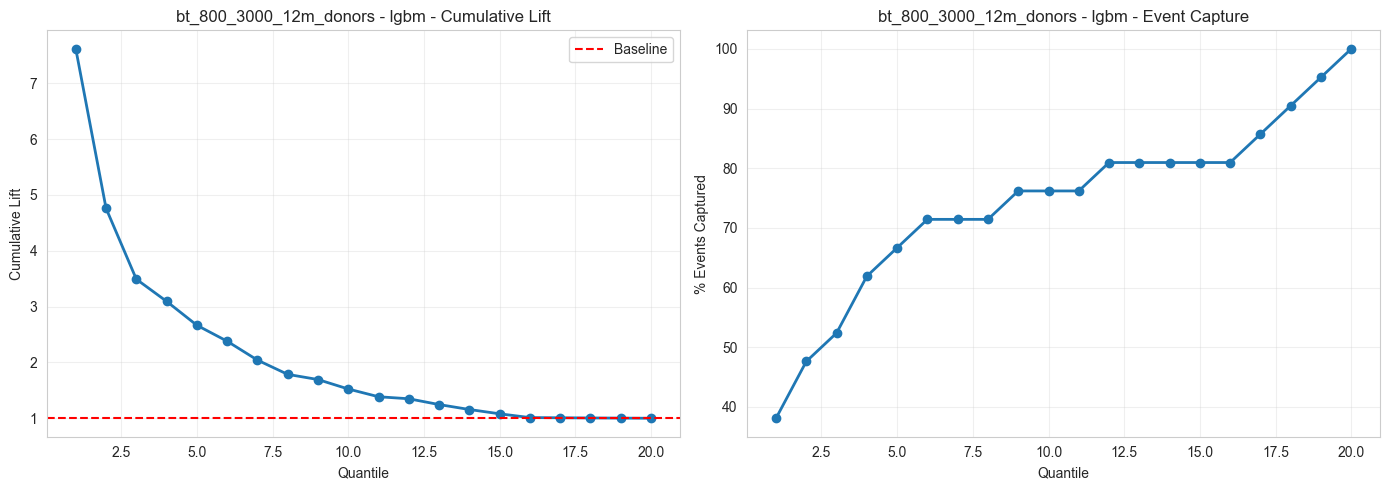

In [14]:
# Show lift table for classification tasks
if results['config']['task_type'] == 'classification':
    MODEL_TO_EXAMINE = 'lgbm'  # Change this to examine different models
    
    if MODEL_TO_EXAMINE in cohort_results['metrics']:
        lift_table = cohort_results['metrics'][MODEL_TO_EXAMINE]['oot']['lift_table']
        
        print(f"\n=== LIFT TABLE: {COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE} ===")
        print(lift_table.to_string(index=False))
        
        # Plot lift curve
        plot_lift_curve(
            lift_table,
            title=f"{COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE}"
        )

### Calibration Plot (Classification Only)

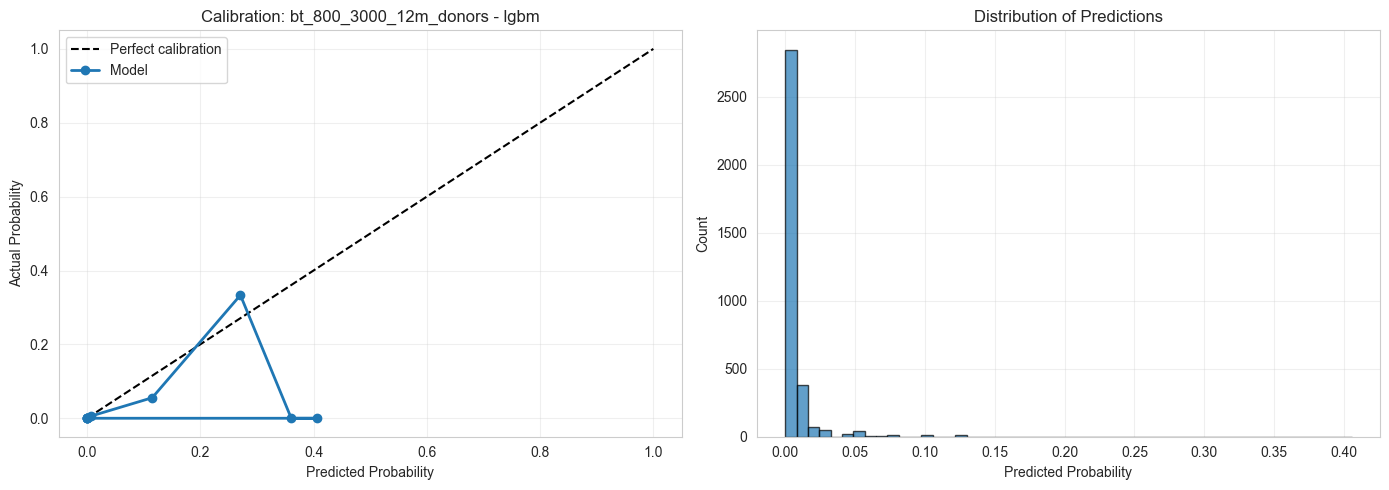

In [15]:
# Calibration curve for classification
if results['config']['task_type'] == 'classification':
    if MODEL_TO_EXAMINE in cohort_results['predictions']:
        oot_pred_df = cohort_results['predictions'][MODEL_TO_EXAMINE]['oot']
        
        plot_calibration_curve(
            y_true=oot_pred_df['actual'].values,
            y_pred_proba=oot_pred_df['predicted'].values,
            title=f"Calibration: {COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE}"
        )

### SHAP Summary Plot


=== SHAP SUMMARY: bt_800_3000_12m_donors - lgbm ===


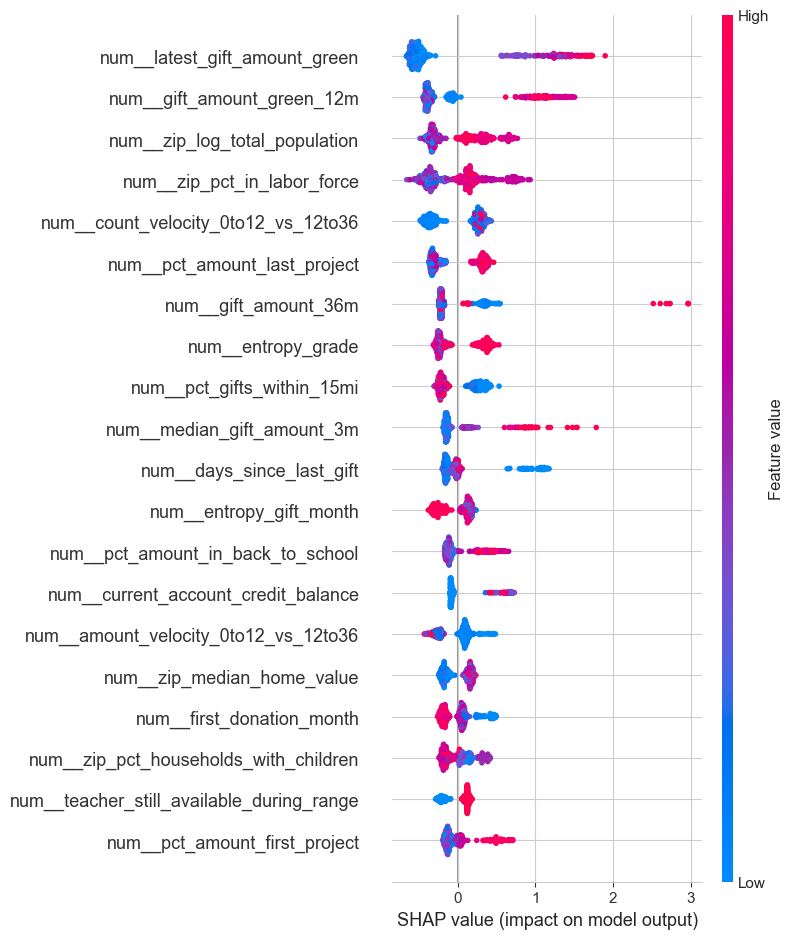


=== Top SHAP Features (by mean |SHAP|) ===
Rank  Feature                                    Mean|SHAP|
-----------------------------------------------------------------
1     num__latest_gift_amount_green                0.694425
2     num__gift_amount_green_12m                   0.496852
3     num__zip_log_total_population                0.316371
4     num__zip_pct_in_labor_force                  0.313209
5     num__count_velocity_0to12_vs_12to36          0.312991
6     num__pct_amount_last_project                 0.312133
7     num__gift_amount_36m                         0.288331
8     num__entropy_grade                           0.279143
9     num__pct_gifts_within_15mi                   0.242959
10    num__median_gift_amount_3m                   0.209037
11    num__days_since_last_gift                    0.187181
12    num__entropy_gift_month                      0.187062
13    num__pct_amount_in_back_to_school            0.172300
14    num__current_account_credit_balance         

In [16]:
# SHAP summary
if SHAP_ENABLED and MODEL_TO_EXAMINE in cohort_results['shap']:
    shap_dict = cohort_results['shap'][MODEL_TO_EXAMINE]
    
    if shap_dict is not None:
        print(f"\n=== SHAP SUMMARY: {COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE} ===")
        plot_shap_summary(shap_dict, top_n=SHAP_TOP_FEATURES)

        df_dir = summarize_shap_direction(
            shap_dict["values"],
            shap_dict["data"],
            shap_dict["feature_names"],
            top_n=20
        )
        print(df_dir.to_string(index=False))
        
    else:
        print(f"⚠️  SHAP values not available for {MODEL_TO_EXAMINE}")
    
else:
    print("⚠️  SHAP not enabled or not available")

### Predictions Sample

In [17]:
# View top predictions
if MODEL_TO_EXAMINE in cohort_results['predictions']:
    oot_pred_df = cohort_results['predictions'][MODEL_TO_EXAMINE]['oot']
    oot_pred_df_sorted = oot_pred_df.sort_values('predicted', ascending=False)
    
    print(f"\n=== TOP 20 PREDICTIONS: {COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE} ===")
    print(oot_pred_df_sorted.head(20).to_string(index=False))
    
    print(f"\n=== BOTTOM 20 PREDICTIONS: {COHORT_TO_EXAMINE} - {MODEL_TO_EXAMINE} ===")
    print(oot_pred_df_sorted.tail(20).to_string(index=False))


=== TOP 20 PREDICTIONS: bt_800_3000_12m_donors - lgbm ===
 donor_id  actual  predicted
3960273.0     0.0   0.405556
9536718.0     0.0   0.376901
2744488.0     0.0   0.344444
6081846.0     0.0   0.295827
3511017.0     0.0   0.268133
  14510.0     1.0   0.248788
6338496.0     0.0   0.127778
3899122.0     0.0   0.127778
2339636.0     0.0   0.127778
7666984.0     1.0   0.127778
2322747.0     0.0   0.127778
 427655.0     0.0   0.127778
2390877.0     0.0   0.127778
4850819.0     0.0   0.127778
6172582.0     0.0   0.127778
1933821.0     0.0   0.102778
8955219.0     0.0   0.102778
 162746.0     0.0   0.102778
7656864.0     0.0   0.102778
2247854.0     0.0   0.102778

=== BOTTOM 20 PREDICTIONS: bt_800_3000_12m_donors - lgbm ===
 donor_id  actual  predicted
 156082.0     0.0        0.0
6326346.0     0.0        0.0
6948562.0     0.0        0.0
4430545.0     0.0        0.0
2641085.0     0.0        0.0
2038307.0     0.0        0.0
4953966.0     0.0        0.0
 947408.0     0.0        0.0
4551036.0

## 7. Export Results

Save models, predictions, metrics, and visualizations.

Exporting results to: modeling_results/run_20251121_170333
✓ Saved config.json
✓ Saved summary.csv
✓ Saved models for bt_800_3000_12m_donors
✓ Saved predictions for bt_800_3000_12m_donors
✓ Saved metrics for bt_800_3000_12m_donors


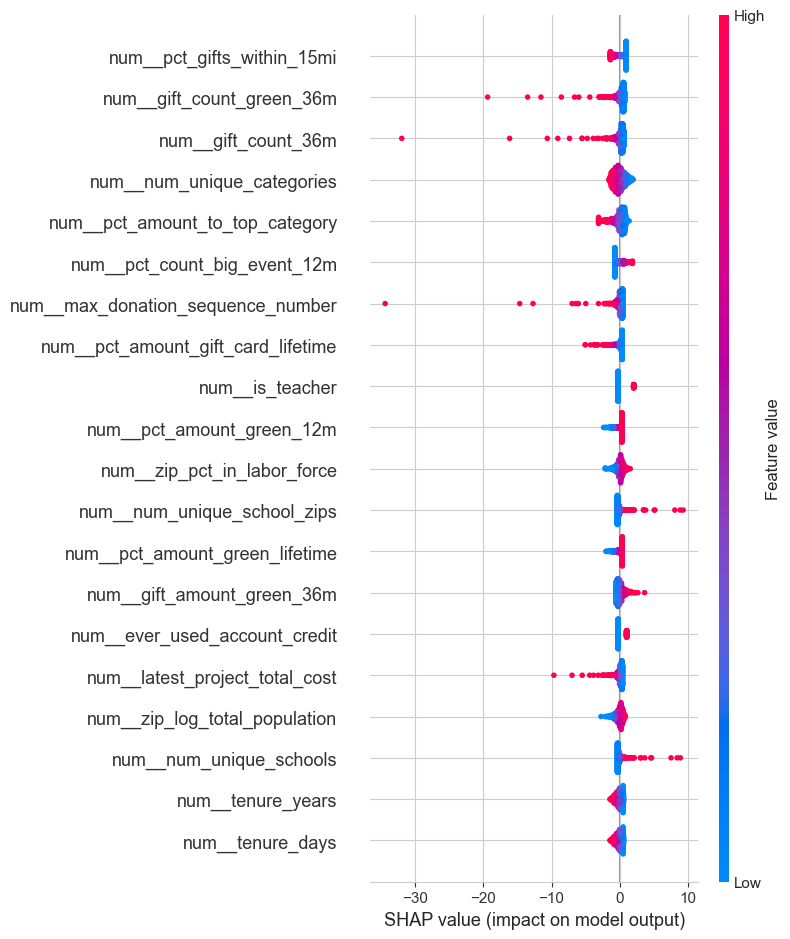


=== Top SHAP Features (by mean |SHAP|) ===
Rank  Feature                                    Mean|SHAP|
-----------------------------------------------------------------
1     num__pct_gifts_within_15mi                   0.796100
2     num__gift_count_green_36m                    0.636527
3     num__gift_count_36m                          0.626904
4     num__num_unique_categories                   0.621618
5     num__pct_amount_to_top_category              0.607938
6     num__pct_count_big_event_12m                 0.544629
7     num__max_donation_sequence_number            0.511979
8     num__pct_amount_gift_card_lifetime           0.429508
9     num__is_teacher                              0.419652
10    num__pct_amount_green_12m                    0.401013
11    num__zip_pct_in_labor_force                  0.387773
12    num__num_unique_school_zips                  0.377667
13    num__pct_amount_green_lifetime               0.369803
14    num__gift_amount_green_36m                  

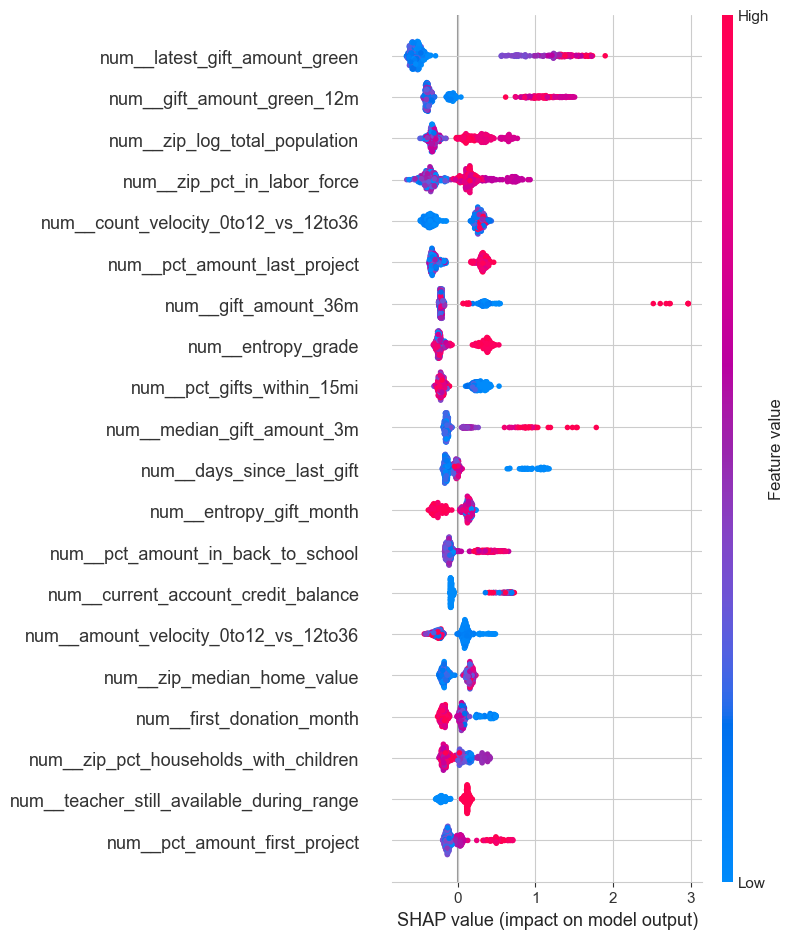


=== Top SHAP Features (by mean |SHAP|) ===
Rank  Feature                                    Mean|SHAP|
-----------------------------------------------------------------
1     num__latest_gift_amount_green                0.694425
2     num__gift_amount_green_12m                   0.496852
3     num__zip_log_total_population                0.316371
4     num__zip_pct_in_labor_force                  0.313209
5     num__count_velocity_0to12_vs_12to36          0.312991
6     num__pct_amount_last_project                 0.312133
7     num__gift_amount_36m                         0.288331
8     num__entropy_grade                           0.279143
9     num__pct_gifts_within_15mi                   0.242959
10    num__median_gift_amount_3m                   0.209037
11    num__days_since_last_gift                    0.187181
12    num__entropy_gift_month                      0.187062
13    num__pct_amount_in_back_to_school            0.172300
14    num__current_account_credit_balance         

In [18]:
import pickle
from datetime import datetime

# Create output directory
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(exist_ok=True, parents=True)

# Create timestamp for this run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = output_dir / f"run_{timestamp}"
run_dir.mkdir(exist_ok=True)

print(f"Exporting results to: {run_dir}")

# Save configuration
with open(run_dir / 'config.json', 'w') as f:
    json.dump(results['config'], f, indent=2)
print("✓ Saved config.json")

# Save summary
results['summary'].to_csv(run_dir / 'summary.csv', index=False)
print("✓ Saved summary.csv")

# Export each cohort's results
for cohort_name, cohort_results in results['cohort_results'].items():
    cohort_dir = run_dir / cohort_name
    cohort_dir.mkdir(exist_ok=True)
    
    # Save models
    if SAVE_MODELS:
        models_dir = cohort_dir / 'models'
        models_dir.mkdir(exist_ok=True)
        
        for model_name, model in cohort_results['models'].items():
            with open(models_dir / f'{model_name}.pkl', 'wb') as f:
                pickle.dump(model, f)
        print(f"✓ Saved models for {cohort_name}")
    
    # Save predictions
    if SAVE_PREDICTIONS:
        pred_dir = cohort_dir / 'predictions'
        pred_dir.mkdir(exist_ok=True)
        
        for model_name, pred_dict in cohort_results['predictions'].items():
            pred_dict['train'].to_csv(pred_dir / f'{model_name}_train.csv', index=False)
            pred_dict['oot'].to_csv(pred_dir / f'{model_name}_oot.csv', index=False)
        print(f"✓ Saved predictions for {cohort_name}")
    
    # Save metrics
    metrics_dir = cohort_dir / 'metrics'
    metrics_dir.mkdir(exist_ok=True)
    
    for model_name, metrics in cohort_results['metrics'].items():
        # Save metrics as JSON (excluding lift_table)
        metrics_clean = {
            'train': {k: v for k, v in metrics['train'].items() if k != 'lift_table'},
            'oot': {k: v for k, v in metrics['oot'].items() if k != 'lift_table'}
        }
        with open(metrics_dir / f'{model_name}_metrics.json', 'w') as f:
            json.dump(metrics_clean, f, indent=2)
        
        # Save lift table separately if classification
        if 'lift_table' in metrics['oot']:
            metrics['oot']['lift_table'].to_csv(
                metrics_dir / f'{model_name}_lift_table.csv',
                index=False
            )
    print(f"✓ Saved metrics for {cohort_name}")
    
    # Save SHAP values
    if SAVE_SHAP and cohort_results['shap']:
        shap_dir = cohort_dir / 'shap'
        shap_dir.mkdir(exist_ok=True)
        
        for model_name, shap_dict in cohort_results['shap'].items():
            if shap_dict is not None:
                # Save SHAP values as CSV
                shap_df = pd.DataFrame(
                    shap_dict['values'],
                    columns=shap_dict['feature_names']
                )
                shap_df.to_csv(shap_dir / f'{model_name}_shap_values.csv', index=False)
                
                # Generate and save SHAP plot
                plot_shap_summary(
                    shap_dict,
                    top_n=SHAP_TOP_FEATURES,
                    output_path=shap_dir / f'{model_name}_shap_summary.png'
                )
        print(f"✓ Saved SHAP for {cohort_name}")

print(f"\n✓ All results exported to: {run_dir}")

## 8. Cross-Cohort Comparison

Compare model performance across all cohorts.

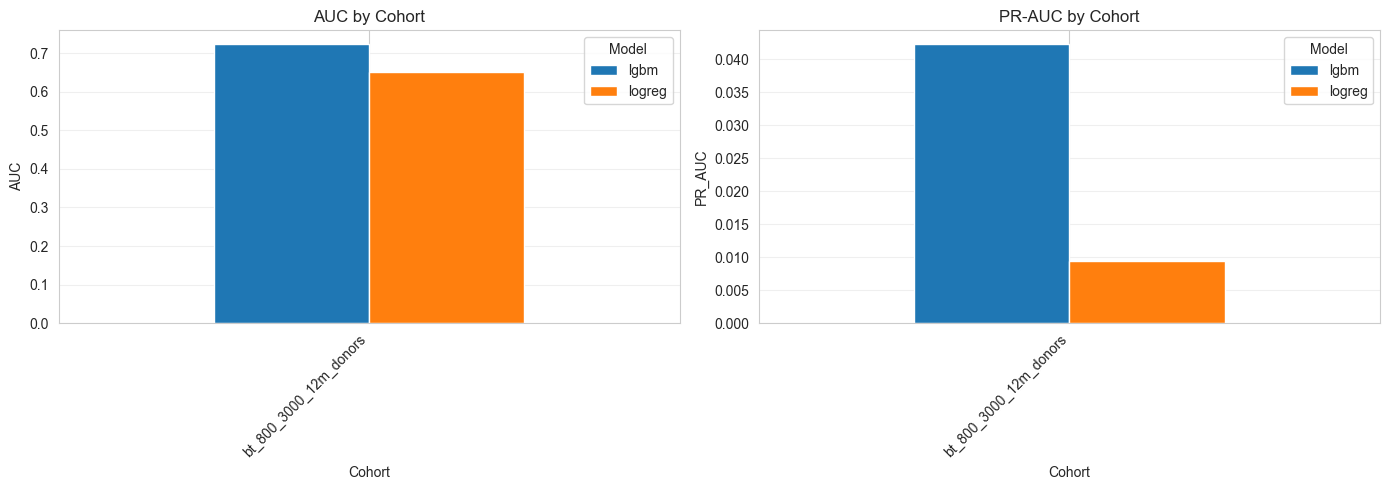

✓ Saved cross_cohort_comparison.png


In [19]:
# Visualize performance across cohorts
task_type = results['config']['task_type']

if task_type == 'classification':
    metric_cols = ['oot_auc', 'oot_pr_auc']
    titles = ['AUC by Cohort', 'PR-AUC by Cohort']
else:
    metric_cols = ['oot_r2', 'oot_rmse']
    titles = ['R² by Cohort', 'RMSE by Cohort']

fig, axes = plt.subplots(1, len(metric_cols), figsize=(14, 5))
if len(metric_cols) == 1:
    axes = [axes]

for ax, metric_col, title in zip(axes, metric_cols, titles):
    pivot = results['summary'].pivot(index='cohort', columns='model', values=metric_col)
    pivot.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cohort')
    ax.set_ylabel(metric_col.replace('oot_', '').upper())
    ax.legend(title='Model')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(run_dir / 'cross_cohort_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"✓ Saved cross_cohort_comparison.png")

## 9. Next Steps

### Using These Results

1. **Review Performance**: Check the summary table and cohort-specific metrics
2. **Inspect Predictions**: Look at top/bottom scored donors in OOT set
3. **Understand Drivers**: Examine SHAP plots to see which features matter most
4. **Select Best Model**: Choose the best performing model for each cohort
5. **Deploy**: Use saved models to score new donors

### Iteration Ideas

- **Try different labels**: Change `LABEL` to predict different outcomes
- **Refine cohorts**: Adjust `COHORTS` to target specific donor segments
- **Tune models**: Modify model hyperparameters in `get_model()`
- **Add features**: Update `donor_feature_construction.ipynb` with new features
- **Change time windows**: Adjust E, T, H, O for different prediction scenarios

### Production Deployment

To score new donors:

```python
# Load saved model
with open('modeling_results/run_XXXXXX/all_donors/models/lgbm.pkl', 'rb') as f:
    model = pickle.load(f)

# Score new data
new_features = pd.read_csv('new_donor_features.csv')
predictions = model.predict_proba(new_features)[:, 1]
```